In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Using downloaded and verified file: data/MNIST\raw\train-images-idx3-ubyte.gz
Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw
0it [00:00, ?it/s]Using downloaded and verified file: data/MNIST\raw\train-labels-idx1-ubyte.gz
Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw
 98%|█████████▊| 1622016/1648877 [00:01<00:00, 820523.02it/s]
0it [00:00, ?it/s]Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw

  0%|          | 0/4542 [00:00<?, ?it/s]Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw
Processing...
Done!


8192it [00:00, 23087.20it/s]            
image.shape: torch.Size([1, 28, 28])
Label: 5


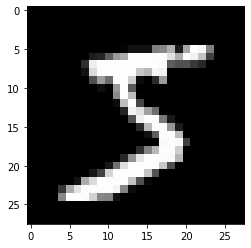

1654784it [00:01, 954264.62it/s]                             


In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


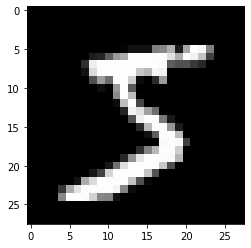

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size=128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


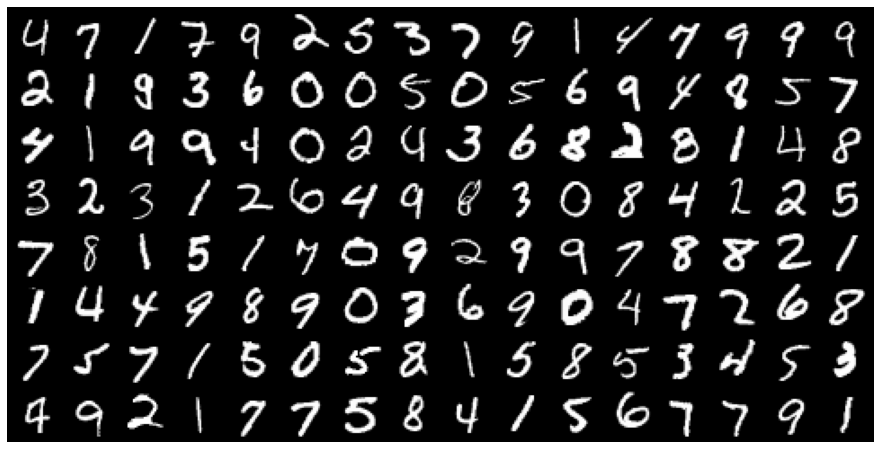

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [8]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [9]:
input_size = inputs.shape[-1]
hidden_size = 32 # learning capacity of the model 

In [10]:
layer1 = nn.Linear(input_size, hidden_size)
inputs.shape

torch.Size([128, 784])

In [11]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [12]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [13]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula relu(x) = max(0,x) i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

In [14]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [15]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.5475590825080872
min(relu_outputs): 0.0


In [16]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [17]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [18]:
inputs.shape

torch.Size([128, 784])

In [19]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2970, grad_fn=<NllLossBackward>)

In [20]:
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias


In [21]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

A deep neural net is simply a neural network with one or more hidden layers. A sufficiently large and deep neural netowkr can compute any arbitary function, ie., it can learn rich and complex non-linear relationshipss betwee inputs / outputs

In [22]:
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias


In [23]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [24]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [25]:
torch.allclose(outputs2, outputs3, 1e-3)

True

In [26]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [27]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [29]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [30]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3003292083740234
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0014,  0.0319,  0.0687,  0.1297,  0.0759, -0.0135, -0.0368, -0.1356,
          0.0353,  0.0456],
        [ 0.0219,  0.1244,  0.0885,  0.0424,  0.0158, -0.0270, -0.0969, -0.2628,
          0.1072,  0.0611]])


In [31]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [32]:
device = get_default_device()
device

device(type='cuda')

In [33]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [34]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break


torch.Size([128, 1, 28, 28])
cuda:0


In [35]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [36]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [37]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [38]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([0, 3, 9, 8, 7, 2, 4, 9, 8, 0, 1, 3, 1, 7, 3, 4, 4, 7, 6, 0, 1, 6, 4, 6,
        0, 2, 8, 1, 6, 8, 9, 5, 2, 8, 3, 9, 5, 6, 6, 4, 0, 0, 2, 1, 8, 2, 8, 2,
        0, 2, 7, 6, 7, 6, 5, 0, 4, 4, 6, 5, 2, 2, 4, 8, 2, 6, 0, 1, 7, 4, 2, 6,
        4, 2, 2, 3, 9, 3, 4, 0, 0, 3, 1, 3, 5, 1, 5, 6, 3, 9, 4, 3, 7, 5, 4, 2,
        2, 0, 9, 8, 0, 4, 8, 1, 9, 7, 1, 4, 5, 2, 3, 9, 0, 1, 8, 6, 5, 7, 6, 0,
        4, 7, 6, 9, 7, 1, 9, 6, 9, 6, 4, 6, 1, 6, 7, 1, 2, 6, 5, 8, 2, 4, 9, 6,
        9, 4, 9, 2, 6, 8, 4, 4, 4, 3, 0, 2, 1, 0, 7, 0, 8, 3, 8, 7, 0, 9, 9, 8,
        9, 5, 9, 0, 1, 5, 1, 6, 0, 8, 1, 5, 6, 7, 9, 9, 9, 8, 1, 8, 7, 1, 4, 6,
        6, 1, 7, 3, 9, 1, 1, 2, 2, 9, 9, 9, 4, 8, 9, 5, 6, 6, 4, 2, 0, 5, 1, 7,
        2, 5, 6, 6, 3, 8, 5, 3, 0, 3, 9, 1, 0, 3, 8, 0, 3, 7, 4, 5, 1, 1, 3, 1,
        6, 0, 2, 3, 5, 5, 4, 5, 5, 6, 2, 7, 2, 0, 8, 0], device='cuda:0')


In [39]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [41]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3149075508117676, 'val_acc': 0.08974609524011612}]

In [42]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2181, val_acc: 0.9351
Epoch [1], val_loss: 0.1650, val_acc: 0.9520
Epoch [2], val_loss: 0.1580, val_acc: 0.9519
Epoch [3], val_loss: 0.1558, val_acc: 0.9561
Epoch [4], val_loss: 0.1492, val_acc: 0.9561


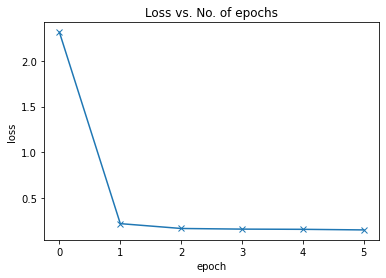

In [43]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

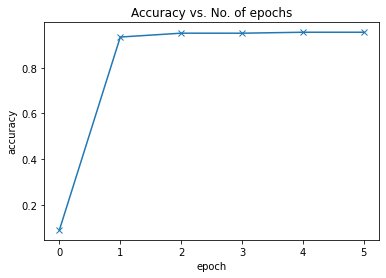

In [44]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [45]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [46]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


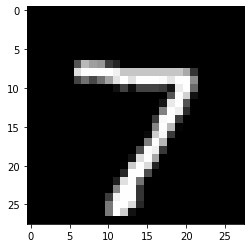

In [47]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


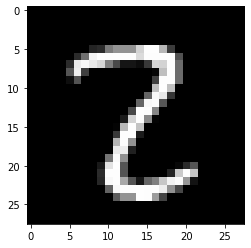

In [48]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [53]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.12770548462867737, 'val_acc': 0.961230456829071}